#Hands-On Machine Learning with Scikit-Learn & TensorFlow 
#Housing Price Example beginning on page 44

I'd like to highlight the fact that this code and dataset came from the O'Reilly textbook Hands-On Machine Learning with Scikit-Learn & TensorFlow written by Aurélien Géron.  Even many sentences came directly from the textbook.  I take no ownership of this material, but rather I'm simply recreating the project in the textbook and documenting the key ideas for my own learning purpose.  For the author's solution himself, see his GitHub page at https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb.  I thank the author for the excellent book that allows readers to walk through several projects while learning.

### Step 1: Get the data and understand its format

First we create a function to fetch the data, so that we can easily re-fetch it later if it was updated or something:

In [1]:
import os
import tarfile
import numpy as np
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We notice that not all entries have a value listed for "total_bedrooms".  All other columns have the entries filled.

Now we'd like to find out what values exist for the "ocean_proximity" column:

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


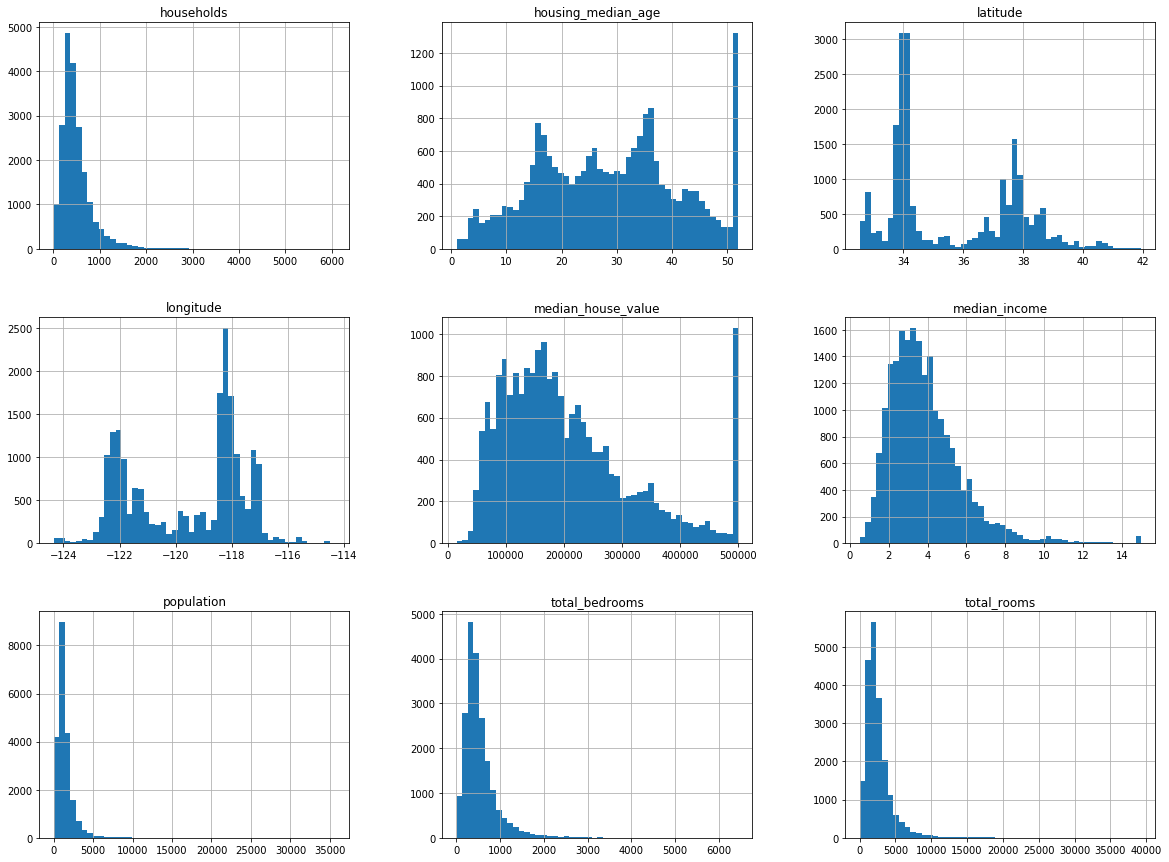

In [8]:
%matplotlib inline
# the above line only works in a Jupyter notebook
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

We see that "housing_median_age" and "median_house_value" are being capped off.  This will create issues later unless we fix this.  

We also notice that the "median_income" isn't just in USD, but instead ranges from 0.4999 to 15.0001.

### Step 2: Before we do anything else, we need to set aside 20% of the data for testing purposes later.

In [9]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

Unfortunately, he housing dataset does not have an identifier column, so we will add column whose entries are the row index number:

In [10]:
housing_with_id = housing.reset_index()

In [11]:
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Now we can use this to ensure that the test set will remain consistent across multiple runs, even if you refresh the dataset.  However, by using the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset and that no row ever gets deleted.  Note: If this is not possible, then you can try to use the most stable features to build a unique identifier or try other options listed on pages 49-51.

In [12]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print len(train_set), "train +", len(test_set), "test"

16362 train + 4278 test


### Alternative way to set aside data: 

Suppose we're told that median income is the most important attribute.  Then we might want to make sure that our test set is representative of the various categories of incomes in the whole data set.  So lets do that.  

First we'll make 5 income categories by first dividing all the incomes by 1.5 (just rescale to work with a smaller range), rounding up to the next whole number (to have discrete categories), and merging all the categories greater than 5 into category 5:

In [13]:
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [14]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


Now we can use Scikit_learn's function called StratifiedShuffleSplit.  

Note: if we just wanted a random test set (like we did above), Scikit_Learn has a function for that too:
<br>
> from sklearn.model_selection import train_test_split
<br>
> train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

To check and see how well it worked, let's look at the proportions of the full housing dataset (we really should've looked at this before to make sure all our categories had a decent number of districts - this is necessary or else the estimate of the stratum's importance may be biased) and also of our strat_test_set.

In [16]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [17]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

It worked!  The strat_test_set now has been built to have correct representation of each income category.

Now we will remove the income_cat attribute so the data is back to its original state:

In [18]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Step 3: Discover and Visualize the Data to Gain Insights

First let's copy the training set so we can play around with it without harming it:

In [19]:
housing = strat_train_set.copy()

#### ---- First we'll look at our geographic information

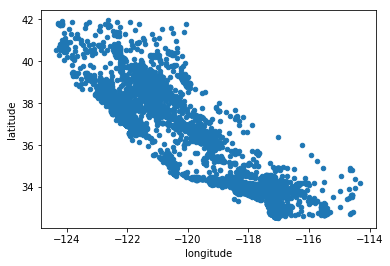

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude")

Setting a small alpha value makes it easier to visualize density of the points:

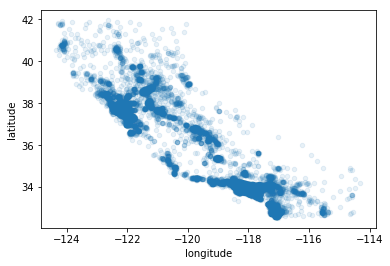

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Now let's also view the district's population (represented by the radius of each circle - option s), and the median house price (represented by the color - option c).  We use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high values):

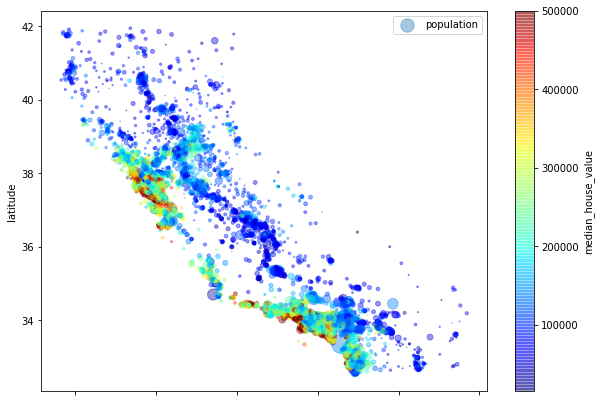

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population", \
             figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

From this we've learned the proximity to the ocean is a huge factor.  The book says population is also seen to be a factor, although personally I don't see that because the dense areas are broken up into many more districts of smaller sizes...I'd say surrounding population is an indicator, but not necessarily the individual district population.

#### --------- Now we'll look at correlations

Since our data set is relatively small, we can compute the correlation coefficient between the median house value and all other attributes:

In [23]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Median income is certainly a huge factor in the housing prices.

Another way to check for correlation between attributes is to use Pandas' scatter_matrix function, which plots every numerical attribute against every other numerical attribute.  Since there are 11 numerical attributes, you would get 121 plots, so instead let's just look at a few promiing ones.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f87c690>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1a71ad90>]], dtype=object)

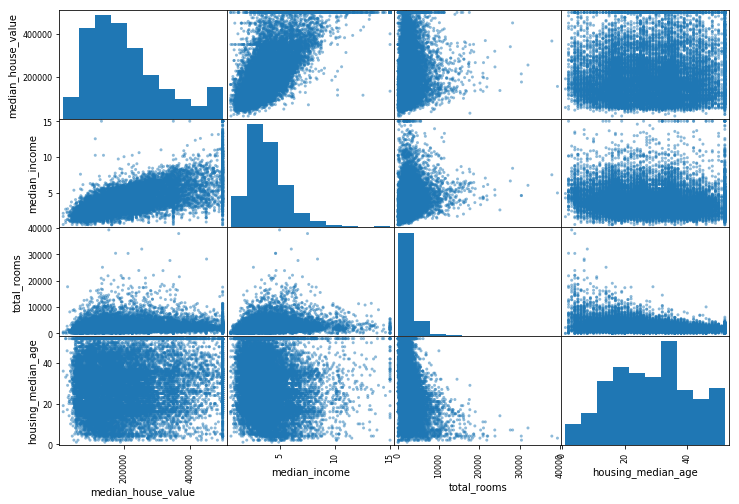

In [24]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

Note: the main diagonal would be full of straight lines if Pandas plotted each variable against inself, so instead Pandas displays a histogram of each attribute (other options are available).

To me, it looks like only the median_income is the only truly correlated looking attribute to the house value, so let's look at just that one.

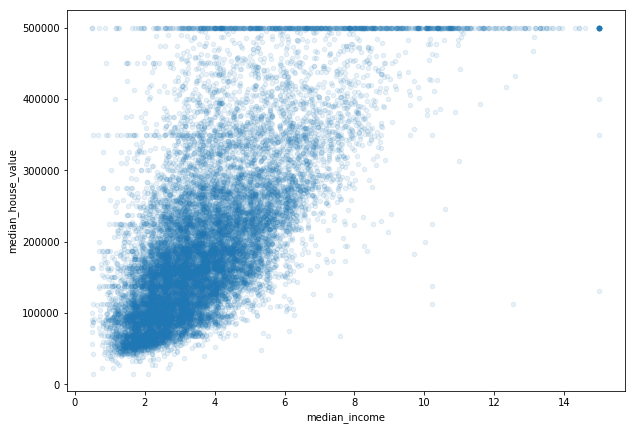

In [25]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, figsize=(10,7))

We see a few unusal straight lines.  First the line at \$500,000 is again caused by the prize cap we noted earlier.  We will need to take care of this.  Also there appear to be some lines around \$450,000, \$350,000, and perhaps \$280,000 and \$220,000.  We should remove these bad points before training our model otherwise it might learn these lines.

#### -------- Experimenting with Attribute Combinations

In [26]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [27]:
corr_matrix=housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

We see the bedrooms_per_room attribute is quite inversely proportional to the median_house_value, i.e. houses with a lower bedroom/room ratio tend to be more expensive.

### Step 4: Prepare the data for machine learning algorithms

It's important to write functions that prepare the data as opposed to doing it manually.  It will save time in the long run.

Let's go back to our clean training set:

In [28]:
housing = strat_train_set.copy()

Let's separate out the median_house_value attribute:

In [29]:
housing_labels = housing["median_house_value"].copy()

In [30]:
housing_labels.head()

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

In [31]:
housing = housing.drop("median_house_value", axis=1)

In [32]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


#### -------- Data Cleaning

Recall that not all districts had a value for total_bedrooms, so we need to fix this.  We have 3 options:

1. Get rid of the corresponding districts
<br>
> housing.dropna(subset=["total_bedrooms"])

1. Get rid of the whole attribute
<br>
> housing.drop("total_bedrooms", axis=1)

1. Set the values to some value (zero, the mean, the median, etc.)
<br>
> median = housing["total_bedrooms"].median()
<br>
> housing["total_bedrooms"].fillna(median, inplace=True)

Note: If you choose option 3, you should compute the median value on the training set, and don't forget to save the median value so you can replace missing values in the test set later when you're evaluating your system, and also once the system goes live to replace missing values in new data.  Furthermore, Scikit-Learn provides a handy class to take care of missing values: Imputer.  Let's try it out.

In [33]:
from sklearn.preprocessing import Imputer

imputer=Imputer(strategy="median")

#since the median can only be computed on numerical attributes, we need to create a copy of the data without 
#the text attribute ocean_proximity

housing_num=housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

The imputer has computed the median of each attribute and stored the results in its statistics_ instance variable

In [34]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [35]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

Now we need to use the imputer to transform the training set by replacing missing values by the learned medians:

In [36]:
X = imputer.transform(housing_num)

Lastly, our result is just an array, so we need to put it back into a Pandas DataFrame:

In [37]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [38]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


Great, they all have all entries filled in.  Now we need to add back our ocean_proximity attribute.

#### -------- Handling Categorical Attributes

We can tranform the text categories into integers, e.g. '<1H OCEAN'=0, 'INLAND'=1, 'ISLAND'=2, etc.  However, this is bad since algorithms will asuume that nearby values are more similar than distant values.  But we can go from these integers to a "one-hot encoding" which will associate the *n* integers with basis vectors in *R^n*, e.g. it associates 0 with the vector $<1,0,0,0,0>$, 1 with the vector $<0,1,0,0,0>$, 2 with the vector $<0,0,1,0,0>$, etc.  We can do these transformations one at a time (see text p. 63-64) or both at once as follows:

In [39]:
housing_cat = housing['ocean_proximity']
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [40]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0])

In [41]:
housing_categories

Index([u'<1H OCEAN', u'NEAR OCEAN', u'INLAND', u'NEAR BAY', u'ISLAND'], dtype='object')

In [42]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<type 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [43]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [44]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [45]:
#from sklearn.preprocessing import CategoricalEncoder # in future versions of Scikit-Learn

cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16512x5 sparse matrix of type '<type 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [46]:
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [47]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype=object)]

#### -------- Custom Transformers

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room 
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[: , rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)

We'd like to use the Scikit-Learn's Pipeline class to help deal with sequences of transformations, but we can't feed a Pandas DataFrame directly into our pipeline.  So instead of having to first manually extract the numerical columns into a NumPy array, we can write a custom transformer for this task.

In [49]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now we can turn our category preprocessing into a class as well, so we can add it to the pipeline.

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

Now to run our whole pipeline we use:

In [51]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [52]:
housing_prepared.shape

(16512, 16)

### Step 5: Select and Train a Model

#### Linear Regression

Let's first train a Linear Regression model and see how it works.

Recall that housing_labels is the list of housing prices from the training set that we set aside.

In [53]:
from sklearn.linear_model import LinearRegression

lin_reg=LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Let's see how it worked on a few instances from the training set:

In [54]:
some_data=housing.iloc[:5]
some_labels=housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print "Predictions:", lin_reg.predict(some_data_prepared)
print "Labels:", list(some_labels)

Predictions: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Let's measure this regression model's RMSE on the whole training set using Scikit-Learn's mean_squared_error function

In [55]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489219

This is ok, but not great.  Most districts' median_housing_values range between \$120,000 and \$265,000, so a typical prediction error of \$68,628 is not satisfying.

Our model is underfitting.  We will need to either use a more powerful model, feed the training algorithm with better features, or reduce the constraints on the model.  This model is not regularized, so this rules out the last option.  We could try to add more features (e.g. the log of the population), but first let's try a more complex model.

***
#### Decision Tree Regressor

Decision Trees are a more powerful model, capable of finding complex nonlinear relationships in the data.

In [56]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Zero error is too good to be true.  Most likely we've badly overfit the data.  To see if that is in fact the case, let's use **cross-validation**.  Setting cv=10, means we're using 10-fold cross validation (split the training data into 10 subsets, then use 9 of them to train and the last to validate, repeat for each subset left out for validation - a total of 10 times).

In [57]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

Let's write a function to display the results:

In [58]:
def display_scores(scores):
    print "Scores:", scores
    print "Mean:", scores.mean()
    print "Standard Deviation:", scores.std()

In [59]:
display_scores(tree_rmse_scores)

Scores: [ 68883.67471536  67444.40145196  70812.03958201  68832.29397717
  69587.4998638   73727.05103082  69188.7802918   72550.93991826
  75181.36444024  69661.32175172]
Mean: 70586.9367023
Standard Deviation: 2335.4430595


We do in fact see that we were overfitting before.  Here, we see the average rmse score of approximately \$70,586, generally $\pm$ \$2,335.  This looks worse than the linear regression model.  In fact, if we go back and use cross validation on the linear regression model, we do in fact see that linear regression was better.

Let's try one more model.

***
#### Random Forest Regressor

Random Forests work by training many Decision Trees on random subset of the features, then averaging out their predictions.  Building a model on top of many other models is called *Ensemble Learning*, and it is ofen a great way to push ML algorithms even further.

In [60]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22034.310771741973

In [61]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [ 52232.43977787  51241.68352768  52036.21952704  53711.76143438
  53050.89378697  55605.35793443  51742.78620921  50892.12680324
  55908.87509565  52601.91891816]
Mean: 52902.4063015
Standard Deviation: 1626.50780183


This is much better than either of the previous two models.  Here, we see the average rmse score of approximately \$52,902, generally $\pm$ \$1,626. Although it's still overfitting, since the overall rmse was given as only \$22,034.  Possible solutions for overfitting are to simplify the model, constrain/regularize it, get a lot more training data, or try a different model.

### Step 6: Fine-Tune the Model

We can fine-tune our model by adjusting hyperparameter values and finding the best ones.  To do this we can use Scikit-Learn's GridSearchCV or RandomizedSearchCV (pg. 75).  Below we'll only use GridSearchCV:

In [63]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [10,30,90], 'max_features': [8,10]},
    {'bootstrap': [False], 'n_estimators': [10, 30], 'max_features': [8,10]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 30, 90], 'max_features': [8, 10]}, {'n_estimators': [10, 30], 'max_features': [8, 10], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In the param_grid above, in the first set of curly braces we have 3 options for n_estimators and 2 options for max_features, so this gives 6 combinations.  Similarly, the second set of curly braces adds 4 more combinations.  So we train 10 different times, using 5-fold cross validation.  Therefore, all in all, there will be 50 rounds of training.

In [64]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 8, 'n_estimators': 30}

In [65]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print np.sqrt(-mean_score), params

51782.1897762 {'max_features': 8, 'n_estimators': 10}
49985.4184743 {'max_features': 8, 'n_estimators': 30}
49398.9737207 {'max_features': 8, 'n_estimators': 90}
52521.5854416 {'max_features': 10, 'n_estimators': 10}
50210.4519276 {'max_features': 10, 'n_estimators': 30}
49632.9083382 {'max_features': 10, 'n_estimators': 90}
51256.4513211 {'max_features': 8, 'n_estimators': 10, 'bootstrap': False}
49219.1444336 {'max_features': 8, 'n_estimators': 30, 'bootstrap': False}
51416.7118114 {'max_features': 10, 'n_estimators': 10, 'bootstrap': False}
49792.7804298 {'max_features': 10, 'n_estimators': 30, 'bootstrap': False}


Great, we found some better parameters which have decreased the rmse down to roughly \$49,219.  

Now let's look at which features ended up being the most important.

In [66]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.13748370e-02,   6.95504000e-02,   4.15006666e-02,
         1.48920976e-02,   1.44028113e-02,   1.48152210e-02,
         1.41234201e-02,   4.00443653e-01,   4.93872661e-02,
         1.12534878e-01,   4.30007611e-02,   3.84549835e-03,
         1.45499054e-01,   1.04365908e-04,   2.01354584e-03,
         2.51152537e-03])

In [67]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.40044365264728049, 'median_income'),
 (0.14549905352211648, 'INLAND'),
 (0.11253487755159433, 'pop_per_hhold'),
 (0.071374836962788443, 'longitude'),
 (0.069550400045122196, 'latitude'),
 (0.049387266074500162, 'rooms_per_hhold'),
 (0.04300076105928137, 'bedrooms_per_room'),
 (0.041500666640558036, 'housing_median_age'),
 (0.014892097624645911, 'total_rooms'),
 (0.014815221018396163, 'population'),
 (0.014402811279482737, 'total_bedrooms'),
 (0.014123420111051216, 'households'),
 (0.0038454983457528961, '<1H OCEAN'),
 (0.0025115253705658451, 'NEAR OCEAN'),
 (0.0020135458391720052, 'NEAR BAY'),
 (0.00010436590769160658, 'ISLAND')]

As we expected from our correlation coefficients early on, the median_income ended up being the most important feature.

### Step 7: Evaluate the System on the Test Set

The last step!  We run our model on our untouched testing data and see how well it does.  We expect it to be slightly worse than the cross validation number above, but hopefully not too much worse.

In [68]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

47146.596707987723

Amazingly, our model actually did a little better than we expected it to do.